# Connecting MLOS to a C++ application

This notebook walks through connecting MLOS to a C++ application within a docker container.
We will start a docker container, and run an MLOS Agent within it. The MLOS Agent will start the actual application, and communicate with it via a shared memory channel.
In this example, the MLOS Agent controls the execution of the workloads on the application, and we will later connect to the agent to optimize the configuration of our application.

The application is a "SmartCache" similar to the one in the SmartCacheOptimization notebook, though with some more parameters to tune.
The source for this example is in the `source/Examples/SmartCache` folder.

## Building the application

To build and run the necessary components for this example you need to create and run a docker image.
To that end, open a separate terminal and go to the MLOS main folder. Within that folder, run the following commands:

1. [Build the Docker image](https://microsoft.github.io/MLOS/documentation/01-Prerequisites/#build-the-docker-image) using the [`Dockerfile`](../../Dockerfile#mlos-github-tree-view) at the root of the repository.

    ```shell
    docker build --build-arg=UbuntuVersion=20.04 -t mlos/build:ubuntu-20.04 .
    ```

2. [Run the Docker image](https://microsoft.github.io/MLOS/documentation/02-Build/#create-a-new-container-instance) you just built.

    ```shell
    docker run -it -v $PWD:/src/MLOS -p 127.0.0.1:50051:50051/tcp \
        --name mlos-build mlos/build:ubuntu-20.04
         
    ```
    This will open a shell inside the docker container.
    We're also exposing port 50051 on the docker container to port 50051 of our host machine.
    This will allow us later to connect to the optimizer that runs inside the docker container.

3. Inside the container, [build the compiled software](https://microsoft.github.io/MLOS/documentation/02-Build/#cli-make) with `make`:

    ```sh
    make dotnet-build cmake-build cmake-install
    ```

The relevant output will be at:

- Mlos.Agent.Server:

    This file corresponds to the main entry point for MLOS, written in C#. You can find the source in
    `source/Mlos.Agent.Server/MlosAgentServer.cs` and the binary at
    `target/bin/Release/Mlos.Agent.Server.dll`

- SmartCache:

    This is the C++ executable that implements the SmartCache and executes some workloads.
    You can find the source in `source/Examples/SmartCache/Main.cpp` and the binary at
    `target/bin/Release/SmartCache`

- SmartCache.SettingsRegistry:

    This is the C# code that declares the configuration options for the SmartCache component, and defines the communication
    between the the MLOS Agent and the SmartCache component. You can find the source in
    `source/Examples/SmartCache/SmartCache.SettingsRegistry/AssemblyInitializer.cs` and the binary at
    `target/bin/Release/SmartCache.SettingsRegistry.dll`
        

## Starting the MLOS Agent and executing the workloads:

Within the docker container, we can now tell the agent where the configuration options are stored, by setting the `MLOS_Settings_REGISTRY_PATH`.
Then, we can run the MLOS Agent, which will in turn run the SmartCache executable.
```sh
export MLOS_SETTINGS_REGISTRY_PATH="target/bin/Release"

tools/bin/dotnet target/bin/Release/Mlos.Agent.Server.dll \
    --executable target/bin/Release/SmartCache
```

The main loop of ``SmartCache`` contains the following:

```cpp
    for (int observations = 0; observations < 100; observations++)
    {
        // run 100 observations
        std::cout << "observations: " << observations << std::endl;

        for (int i = 0; i < 20; i++)
        {
            // run a workload 20 times
            CyclicalWorkload(2048, smartCache);
        }

        bool isConfigReady = false;
        std::mutex waitForConfigMutex;
        std::condition_variable waitForConfigCondVar;

        // Setup a callback.
        //
        // OMMITTED
        // [...]

        // Send a request to obtain a new configuration.
        SmartCache::RequestNewConfigurationMessage msg = { 0 };
        mlosContext.SendTelemetryMessage(msg);
        // wait for MLOS Agent so send a message with a new configuration
        std::unique_lock<std::mutex> lock(waitForConfigMutex);
        while (!isConfigReady)
        {
            waitForConfigCondVar.wait(lock);
        }

        config.Update();
        smartCache.Reconfigure();
    }
```

After each iteration, a TelemetryMessage is sent to the MLOS Agent, and the SmartCache blocks until it receives a new configuration to run the next workload.
By default, the agent is not connected to any optimizer, and will not change the original configuration, so the workload will just run uninterrupted.

## Starting an Optimizer
We can now also start an Optimizer service for the MLOS Agent to connect to so that we can actually optimize the parameters for this workload.
As the optimizer is running in a separate process, we need to create a new shell on the running docker container using the following command:

```shell
docker exec -it mlos-build /bin/bash
```

Within the container, we now install the Python optimizer service:
```shell
pip install -e source/Mlos.Python/
```

And run it:
```shell
start_optimizer_microservice launch --port 50051
```


## Connecting the Agent to the Optimizer
Now we can start the agent again, this time also pointing it to the optimizer:
```sh
tools/bin/dotnet target/bin/Release/Mlos.Agent.Server.dll \
    --executable target/bin/Release/SmartCache \
    --optimizer-uri http://localhost:50051
```

This will run the workload again, this time using the optimizer to suggest better configurations. You should see output both in the terminal the agent is running in and in the terminal the OptimizerMicroservice is running in.

## Inspecting results
After (or even while) the optimization is running, we can connect to the optimizer via another GRPC channel.
The optimizer is running within the docker container, but when we started docker, we exposed the port 50051 as the same port 50051 on the host machine (on which this notebook is running). So we can now connect to the optimizer within the docker container at `127.0.0.1:50051`.
This assumes this notebook runs in an environment with the `mlos` Python package installed ([see the documentation](https://microsoft.github.io/MLOS/documentation/01-Prerequisites/#python-quickstart)).

In [1]:
from mlos.Grpc.OptimizerMonitor import OptimizerMonitor
import grpc
# create a grpc channel and instantiate the OptimizerMonitor
channel = grpc.insecure_channel('127.0.0.1:50051')
optimizer_monitor = OptimizerMonitor(grpc_channel=channel)
optimizer_monitor

In [75]:
# There should be one optimizer running in the docker container
# corresponding to the C++ SmartCache optimization problem
# An OptimizerMicroservice can run multiple optimizers, which would all be listed here
optimizers = optimizer_monitor.get_existing_optimizers()
optimizers

We can now get the observations exactly the same way as for the Python example in `SmartCacheOptimization.ipynb`

In [76]:
optimizer = optimizers[-1]
features_df, objectives_df = optimizer.get_all_observations()

In [77]:
[i.optimum() for i in optimizers]

[None, None, None, None]

In [78]:
import pandas as pd
features, targets = optimizer.get_all_observations()
data = pd.concat([features, targets], axis=1)
data

,cache_implementation,lfu_cache_config.cache_size,mru_cache_config.cache_size,lru_cache_config.cache_size,HitRate
0,LeastRecentlyUsed,NaN,NaN,100.0,0.422596
1,LeastFrequentlyUsed,690.0,NaN,NaN,0.518383
2,LeastFrequentlyUsed,194.0,NaN,NaN,0.516675
3,MostRecentlyUsed,NaN,2314.0,NaN,0.518953
4,LeastRecentlyUsed,NaN,NaN,2464.0,0.424026
...,...,...,...,...,...
95,LeastFrequentlyUsed,2787.0,NaN,NaN,0.518883
96,MostRecentlyUsed,NaN,2672.0,NaN,0.518965
97,MostRecentlyUsed,NaN,1076.0,NaN,0.518843
98,LeastFrequentlyUsed,386.0,NaN,NaN,0.517858


Text(0.5, 1.0, 'LFU-Friendly Workload')

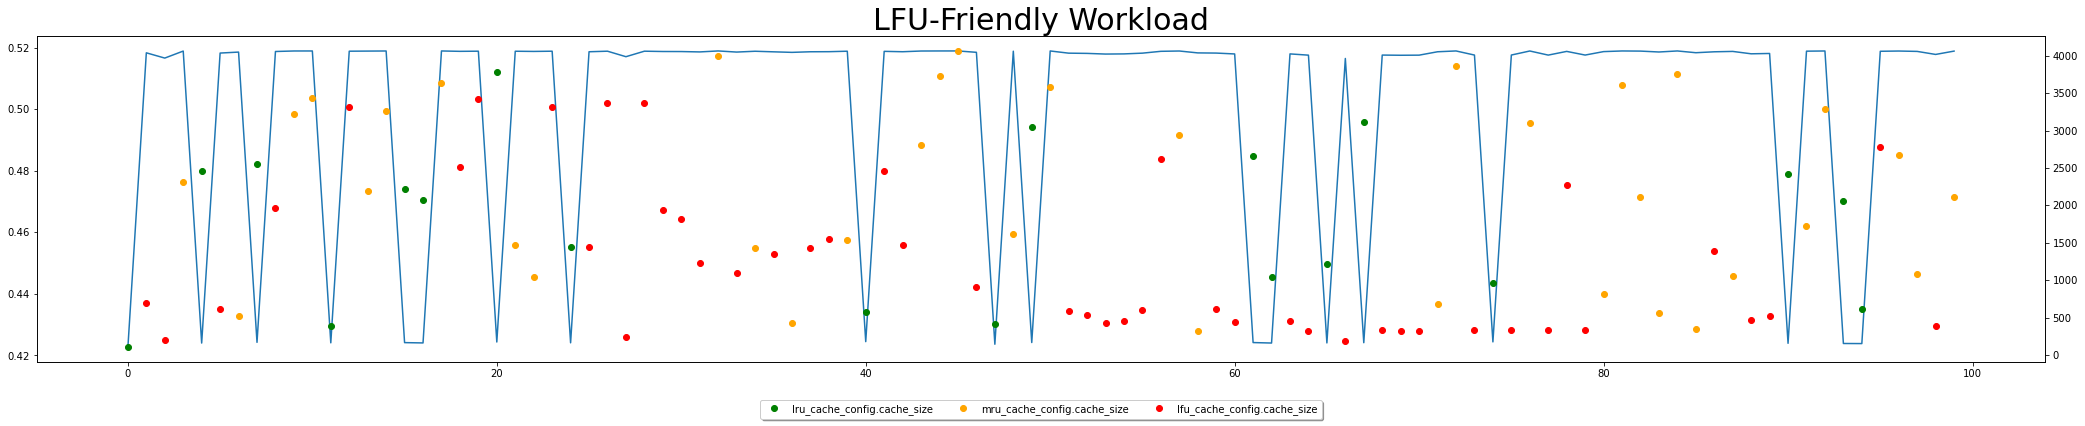

In [80]:
lfu_data, lru_data, mru_data = data.groupby('cache_implementation')
a = data.plot(y = "HitRate", figsize=(36, 6), legend=False)
b = lru_data[1].plot(
    y = "lru_cache_config.cache_size", ax=a, secondary_y=True, color='g', marker='o', linestyle='none', legend=False)
c = mru_data[1].plot(
    y = "mru_cache_config.cache_size", ax=b, secondary_y=True, color='orange', marker='o', linestyle='none', legend=False)
d = lfu_data[1].plot(
    y = "lfu_cache_config.cache_size", ax=c, secondary_y=True, color='r', marker='o', linestyle='none', legend=False)
d.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=3, fancybox=True, shadow=True)
d.set_title("LFU-Friendly Workload", size=30)

Text(0.5, 1.0, 'LFU-Friendly Workload')

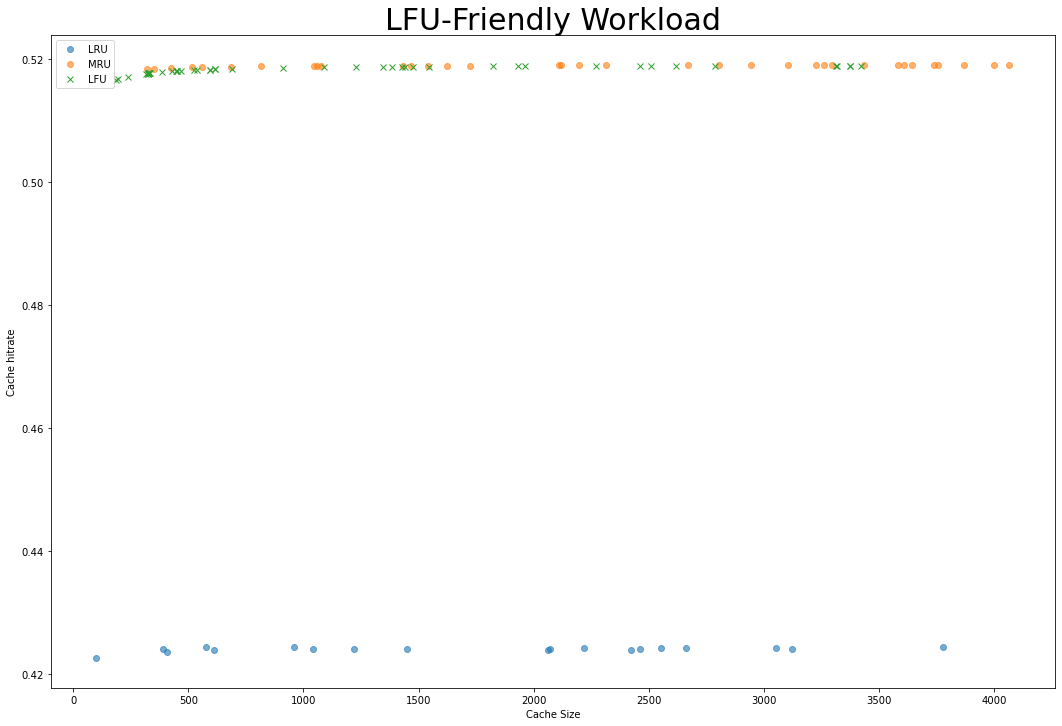

In [82]:
lfu_data, lru_data, mru_data = data.groupby('cache_implementation')

import matplotlib.pyplot as plt
line_lru = lru_data[1].plot(
    x='lru_cache_config.cache_size', y='HitRate', label='LRU', marker='o', linestyle='none', alpha=.6, figsize=(18, 12))
mru_data[1].plot(
    x='mru_cache_config.cache_size', y='HitRate', label='MRU', marker='o', linestyle='none', alpha=.6, ax=plt.gca())
lfu_data[1].plot(
    x='lfu_cache_config.cache_size', y='HitRate', label='LFU', marker='x', linestyle='none', alpha=1, ax=plt.gca())
plt.ylabel("Cache hitrate")
plt.xlabel("Cache Size")
plt.legend()
line_lru.set_title("LFU-Friendly Workload", size=30)

# Going Further
1. Instead of cache hit rate, use a metric based on runtime (e.g. latency, throughput, etc) as performance metric. Environment (context) sensitive metrics can also be measured (e.g. [time](https://bduvenhage.me/performance/2019/06/22/high-performance-timer.html). How does the signal from the runtime based metric compare to the application specific one (hit rate)? How consistent are the runtime results across multiple runs?
2. Pick another widely used [cache replacement policy](https://en.wikipedia.org/wiki/Cache_replacement_policies) such as LFU and construct a synthetic workload on which you expect this strategy to work well. Implement the policy and workload as part of the SmartCache example, and add a new option to the ``SmartCache.SettingsRegistry\AssemblyInitializer.cs``. Run the optimization again with your new workload. Does the optimizer find that your new policy performs best?

## Questions

Why does the optimum value does not show up when we type
```
optimizer.optimum()
```